In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
if not tf.test.is_gpu_available():
    print('GPU is not available. Runtime -> Change runtime type to enable GPU')

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def build_dataset(dtype, visualize=False):
    if dtype == 'mnist_dnn':
        import tensorflow as tf
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
        
        X_train = X_train.reshape((60000, 28*28)) / 255.0
        X_test = X_test.reshape((10000, 28*28)) / 255.0
        if visualize:
            id = 0
            plt.figure()
            plt.imshow(X_train[id].reshape(28, 28))
            plt.title('class {}'.format(y_train[id]))
    elif dtype == 'mnist_cnn':
        import tensorflow as tf
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
        
        X_train = X_train.reshape((60000, 28, 28, 1)) / 255.0
        X_test = X_test.reshape((10000, 28, 28, 1)) / 255.0
        if visualize:
            id = 0
            plt.figure()
            plt.imshow(X_train[id].reshape(28, 28))
            plt.title('class {}'.format(y_train[id]))
    else:
        raise NotImplementedError
    return X_train, y_train, X_test, y_test

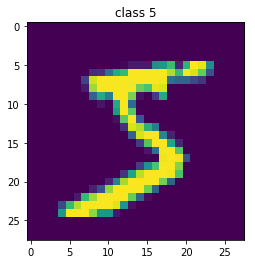

In [3]:
_ = build_dataset('mnist_cnn', visualize=True)

In [4]:
def build_model(mtype, cdim=64, ddim=64):
    if mtype == 'dnn':
        from tensorflow.keras import layers, models
        model = models.Sequential()
        model.add(layers.Dense(units=128, activation='relu', input_shape=(28*28,)))
        model.add(layers.Dense(units=10, activation='softmax'))
        model.summary()
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        clf = model

    elif mtype == 'cnn':
        from tensorflow.keras import layers, models
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(cdim, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(ddim, activation='relu'))
        model.add(layers.Dense(10, activation='softmax'))
        model.summary()
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        clf = model

    else:
        raise NotImplementedError
    return clf

In [5]:
def train_tf(config={}):
    X_train, y_train, X_test, y_test = build_dataset(config['dataset'])
    clf = build_model(config['model'])
    
    clf.fit(X_train, y_train, epochs=5)
    test_loss, test_acc = clf.evaluate(X_test, y_test, verbose=2)
    
    print('test accuracy: {}, loss: {}'.format(test_acc, test_loss))

In [6]:
%%time
train_tf({'dataset': 'mnist_dnn', 'model': 'dnn'})

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2601 - accuracy: 0.9266
Epoch 2/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.1137 - accuracy: 0.9669
Epoch 3/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0790 - accuracy: 0.9764
Epoch 4/5
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0585 - accuracy: 0.9819
Epoch 5/5
60000/60000 [==============================] - 3s 49us/

In [7]:
%%time
train_tf({'dataset': 'mnist_cnn', 'model': 'cnn'})

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [ ]:
print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q -U ray[tune]
!pip install -q ray[debug]

# A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash (this is not an issue).")
import os
os._exit(0)

In [ ]:
import ray
from ray import tune

In [ ]:
from tensorflow import keras
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))

In [ ]:
def train_tf(config={}):
    X_train, y_train, X_test, y_test = build_dataset(config['dataset'])
    clf = build_model(config['model'], config['cdim'], config['ddim'])
    
    callbacks = [TuneReporterCallback()]
    clf.fit(X_train, y_train, epochs=5, callbacks=callbacks)
    test_loss, test_acc = clf.evaluate(X_test, y_test, verbose=2)
    tune.report(mean_accuracy = test_acc)
    
    print('test accuracy: {}, loss: {}'.format(test_acc, test_loss))

In [ ]:
hyperparameter_space = {
    'model': 'cnn',
    'dataset': 'mnist_cnn',
    'cdim': tune.grid_search([64, 128, 256]),
    'ddim': tune.grid_search([64, 128, 256]),
}
ray.shutdown()
ray.init(log_to_driver=False)
! rm -rf ~/ray_results/train_tf

analysis = tune.run(
    train_tf, 
    verbose=1, 
    resources_per_trial={'gpu': 1},
    config=hyperparameter_space)
